# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [42]:
# Load the libraries
import pandas as pd
import os
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
#from sklearn.preprocessing import FunctionTransformer #works but replacing with PowerTransformer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
#from sklearn.neighbors import KNeighborsRegressor #works but replacing with Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.metrics import mean_squared_error
import shap

In [43]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [44]:
fires_dt

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


# Get X and Y

Create the features data frame and target data.

In [45]:
#Check which columns have normal distribution because preprocessing requires different treatment based on distribution 
num_columns = ['ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area']
skew = fires_dt[num_columns].skew()
kurt = fires_dt[num_columns].kurt()
skew_kurt_df = pd.DataFrame({'skew': skew, 'kurt': kurt})
print(skew_kurt_df) 


           skew        kurt
ffmc  -6.575606   67.066041
dmc    0.547498    0.204822
dc    -1.100445   -0.245244
isi    2.536325   21.458037
temp  -0.331172    0.136166
rh     0.862904    0.438183
wind   0.571001    0.054324
rain  19.816344  421.295964
area  12.846934  194.140721


In [5]:
#Transform Y because it is highly skewed (The data source website suggests the same)
#fires_dt_new = fires_dt.assign(area_log = np.log(fires_dt["area"] + 1))
#fires_dt_new

In [46]:
#Identify X and Y
no_change_cols = ['coord_x', 'coord_y']
cat_cols = ['month', 'day']
num_feature_cols = ['ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
normal_feature_cols = ['dmc', 'temp', 'rh', 'wind'] #features with normal distribution
skewed_feature_cols = ['ffmc', 'dc', 'isi', 'rain'] #features with skewed distribution
target_column = ['area']

X = fires_dt[no_change_cols + cat_cols + normal_feature_cols + skewed_feature_cols]
Y = fires_dt[target_column]

In [47]:
#Create train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=100)

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [48]:
#Apply column transformers. We are keeping all data points. 
preproc1 = ColumnTransformer([('scale_num_cols', StandardScaler(), num_feature_cols),('encode_cat_col', OneHotEncoder(handle_unknown='infrequent_if_exist',drop='if_binary'), cat_cols)], remainder ='passthrough')
preproc1


ColumnTransformer(remainder='passthrough',
                  transformers=[('scale_num_cols', StandardScaler(),
                                 ['ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh',
                                  'wind', 'rain']),
                                ('encode_cat_col',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='infrequent_if_exist'),
                                 ['month', 'day'])])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [49]:
#For features that have skewed distribution, transform first and then scale using a pipeline. 
skewed_pipeline = Pipeline([('power_transform', PowerTransformer(method='yeo-johnson')), ('scale', StandardScaler())]) #Removed FunctionTransformer(np.log1p)

#Apply all column transformers
preproc2 = ColumnTransformer([
    ('trans_scale_skewed_cols', skewed_pipeline, skewed_feature_cols), 
    ('encode_cat_cols', OneHotEncoder(handle_unknown='infrequent_if_exist',drop='if_binary'), cat_cols),
    ('scale_normal_cols', StandardScaler(), normal_feature_cols),
    ], remainder='passthrough')
preproc2

ColumnTransformer(remainder='passthrough',
                  transformers=[('trans_scale_skewed_cols',
                                 Pipeline(steps=[('power_transform',
                                                  PowerTransformer()),
                                                 ('scale', StandardScaler())]),
                                 ['ffmc', 'dc', 'isi', 'rain']),
                                ('encode_cat_cols',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='infrequent_if_exist'),
                                 ['month', 'day']),
                                ('scale_normal_cols', StandardScaler(),
                                 ['dmc', 'temp', 'rh', 'wind'])])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [50]:
# Pipeline A = preproc1 + baseline
pipe_A = Pipeline([('preproc1', preproc1), ('baselinereg', Ridge())]) #Replaced KNeighborsRegressor
pipe_A

Pipeline(steps=[('preproc1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale_num_cols',
                                                  StandardScaler(),
                                                  ['ffmc', 'dmc', 'dc', 'isi',
                                                   'temp', 'rh', 'wind',
                                                   'rain']),
                                                 ('encode_cat_col',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='infrequent_if_exist'),
                                                  ['month', 'day'])])),
                ('baselinereg', Ridge())])

In [51]:
# Pipeline B = preproc2 + baseline
pipe_B = Pipeline([('preproc2', preproc2), ('baselinereg', Ridge())]) #Replaced KNeighborsRegressor
pipe_B

Pipeline(steps=[('preproc2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('trans_scale_skewed_cols',
                                                  Pipeline(steps=[('power_transform',
                                                                   PowerTransformer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['ffmc', 'dc', 'isi',
                                                   'rain']),
                                                 ('encode_cat_cols',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='infrequent_if_exist'),
                                                  ['month', 'day']),
                                                 ('scale_normal_cols',
                                                  StandardScaler(),
                                                  ['dmc', 'temp', 'rh',
                                                   'wind'])])),
                ('baselinereg', Ridge())])

In [52]:
# Pipeline C = preproc1 + advanced model
pipe_C = Pipeline([('preproc1', preproc1), ('advancedreg', RandomForestRegressor())])
pipe_C

Pipeline(steps=[('preproc1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale_num_cols',
                                                  StandardScaler(),
                                                  ['ffmc', 'dmc', 'dc', 'isi',
                                                   'temp', 'rh', 'wind',
                                                   'rain']),
                                                 ('encode_cat_col',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='infrequent_if_exist'),
                                                  ['month', 'day'])])),
                ('advancedreg', RandomForestRegressor())])

In [53]:
# Pipeline D = preproc2 + advanced model
pipe_D = Pipeline([('preproc2', preproc2), ('advancedreg', RandomForestRegressor())])
pipe_D
    

Pipeline(steps=[('preproc2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('trans_scale_skewed_cols',
                                                  Pipeline(steps=[('power_transform',
                                                                   PowerTransformer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['ffmc', 'dc', 'isi',
                                                   'rain']),
                                                 ('encode_cat_cols',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='infrequent_if_exist'),
                                                  ['month', 'day']),
                                                 ('scale_normal_cols',
                                                  StandardScaler(),
                                                  ['dmc', 'temp', 'rh',
                                                   'wind'])])),
                ('advancedreg', RandomForestRegressor())])

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [54]:
pipe_A.get_params()

{'memory': None,
 'steps': [('preproc1',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('scale_num_cols', StandardScaler(),
                                    ['ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh',
                                     'wind', 'rain']),
                                   ('encode_cat_col',
                                    OneHotEncoder(drop='if_binary',
                                                  handle_unknown='infrequent_if_exist'),
                                    ['month', 'day'])])),
  ('baselinereg', Ridge())],
 'verbose': False,
 'preproc1': ColumnTransformer(remainder='passthrough',
                   transformers=[('scale_num_cols', StandardScaler(),
                                  ['ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh',
                                   'wind', 'rain']),
                                 ('encode_cat_col',
                                  OneHotEncoder(drop='if_binary',
                

In [55]:
#Define hyperparameter for Pipe A and Pipe B
knn_param_grid = {'baselinereg__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000]} #Replaced baselinereg__n_neighbors

In [56]:
#Fit the Pipe A model with different combinations of hyperparamters in 5 folds
gridsearch = GridSearchCV(
    estimator=pipe_A,
    param_grid=knn_param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    refit='neg_root_mean_squared_error'
)
gridsearch.fit(X_train, Y_train)

c:\Users\syeolekar\.conda\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\syeolekar\.conda\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\syeolekar\.conda\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\syeolekar\.conda\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\sye

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc1',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scale_num_cols',
                                                                         StandardScaler(),
                                                                         ['ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('encode_cat_col',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='infrequent_if_exist'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('baselinereg', Ridge())]),
             param_grid={'baselinereg__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10,
                                                100, 500, 1000]},
             refit='neg_root_mean_squared_error',
             scoring='neg_root_mean_squared_error')

In [57]:
#Find the results of Pipe A model
results = pd.DataFrame(gridsearch.cv_results_)
results 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_baselinereg__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.034561,0.030311,0.010648,0.002938,0.0001,{'baselinereg__alpha': 0.0001},-31.630084,-28.593519,-42.838174,-35.006632,-145.209044,-56.655490,44.531042,9
1,0.021478,0.004143,0.009733,0.000608,0.0010,{'baselinereg__alpha': 0.001},-31.629298,-28.590420,-42.837657,-35.006645,-145.209221,-56.654649,44.531622,8
2,0.017331,0.007382,0.011395,0.002059,0.0100,{'baselinereg__alpha': 0.01},-31.621519,-28.559906,-42.832556,-35.006822,-145.210989,-56.646359,44.537346,7
3,0.012118,0.004883,0.007390,0.003220,0.1000,{'baselinereg__alpha': 0.1},-31.550738,-28.295270,-42.787085,-35.011827,-145.227556,-56.574495,44.587688,6
4,0.012640,0.003404,0.005288,0.002888,1.0000,{'baselinereg__alpha': 1},-31.110774,-27.244909,-42.532247,-35.089789,-145.325904,-56.260725,44.819021,5
5,0.009380,0.003938,0.008512,0.004014,10.0000,{'baselinereg__alpha': 10},-29.039116,-26.229736,-41.519701,-34.672157,-145.438293,-55.379801,45.332105,4
6,0.012296,0.003469,0.004780,0.004832,100.0000,{'baselinereg__alpha': 100},-24.618552,-25.300393,-39.366984,-32.177770,-145.413280,-53.375396,46.328628,3
7,0.012105,0.003810,0.007479,0.001172,500.0000,{'baselinereg__alpha': 500},-21.065369,-25.004208,-38.493817,-30.151282,-145.603951,-52.063725,47.132127,2
8,0.010119,0.001866,0.010421,0.001858,1000.0000,{'baselinereg__alpha': 1000},-20.144275,-24.973511,-38.286402,-29.370689,-145.707469,-51.696469,47.383533,1


In [58]:
#Pipe A - convert results positive because scikit maximizes scores and makes it negative.
results["mean_test_score"] = -results["mean_test_score"]
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_baselinereg__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.034561,0.030311,0.010648,0.002938,0.0001,{'baselinereg__alpha': 0.0001},-31.630084,-28.593519,-42.838174,-35.006632,-145.209044,56.655490,44.531042,9
1,0.021478,0.004143,0.009733,0.000608,0.0010,{'baselinereg__alpha': 0.001},-31.629298,-28.590420,-42.837657,-35.006645,-145.209221,56.654649,44.531622,8
2,0.017331,0.007382,0.011395,0.002059,0.0100,{'baselinereg__alpha': 0.01},-31.621519,-28.559906,-42.832556,-35.006822,-145.210989,56.646359,44.537346,7
3,0.012118,0.004883,0.007390,0.003220,0.1000,{'baselinereg__alpha': 0.1},-31.550738,-28.295270,-42.787085,-35.011827,-145.227556,56.574495,44.587688,6
4,0.012640,0.003404,0.005288,0.002888,1.0000,{'baselinereg__alpha': 1},-31.110774,-27.244909,-42.532247,-35.089789,-145.325904,56.260725,44.819021,5
5,0.009380,0.003938,0.008512,0.004014,10.0000,{'baselinereg__alpha': 10},-29.039116,-26.229736,-41.519701,-34.672157,-145.438293,55.379801,45.332105,4
6,0.012296,0.003469,0.004780,0.004832,100.0000,{'baselinereg__alpha': 100},-24.618552,-25.300393,-39.366984,-32.177770,-145.413280,53.375396,46.328628,3
7,0.012105,0.003810,0.007479,0.001172,500.0000,{'baselinereg__alpha': 500},-21.065369,-25.004208,-38.493817,-30.151282,-145.603951,52.063725,47.132127,2
8,0.010119,0.001866,0.010421,0.001858,1000.0000,{'baselinereg__alpha': 1000},-20.144275,-24.973511,-38.286402,-29.370689,-145.707469,51.696469,47.383533,1


In [59]:
#Pipe A - find best params
gridsearch.best_params_

{'baselinereg__alpha': 1000}

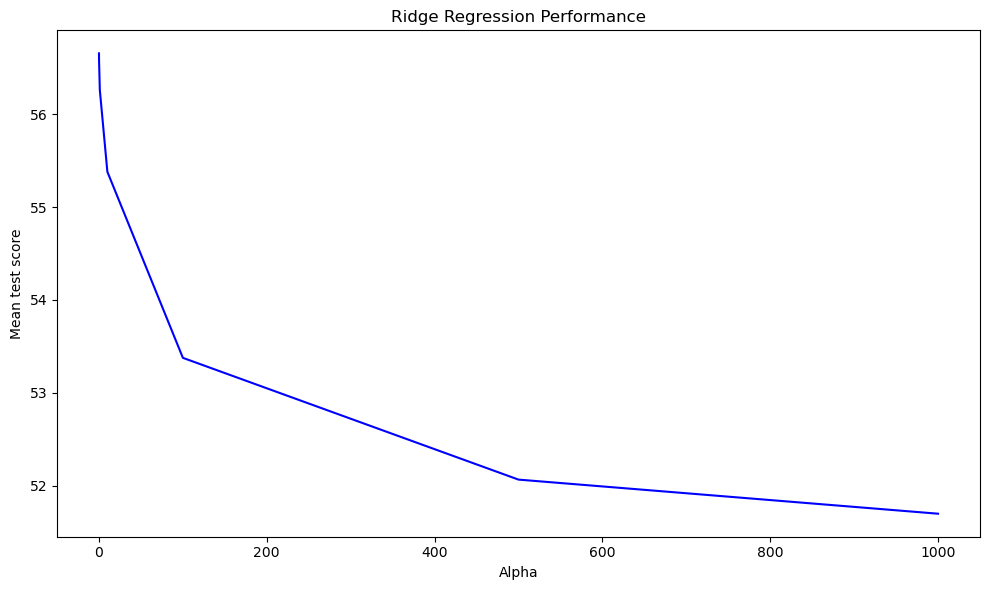

In [60]:
#Pipe A - find elbow
# Create the plot
plt.figure(figsize=(10, 6))

# Plot mean test scores with error bars
plt.plot(results['param_baselinereg__alpha'], results['mean_test_score'], color='blue')

# Add labels and legend
plt.xlabel('Alpha')
plt.ylabel('Mean test score')
plt.title('Ridge Regression Performance')
plt.tight_layout()
plt.show()

In [61]:
#Fit the Pipe B model with different combinations of hyperparameters in 5 folds
gridsearch2 = GridSearchCV(
    estimator=pipe_B, 
    param_grid=knn_param_grid, 
    scoring="neg_root_mean_squared_error",
    cv=5,
    refit="neg_root_mean_squared_error"
)
gridsearch2.fit(X_train, Y_train)


c:\Users\syeolekar\.conda\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\syeolekar\.conda\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\syeolekar\.conda\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\syeolekar\.conda\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\sye

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc2',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('trans_scale_skewed_cols',
                                                                         Pipeline(steps=[('power_transform',
                                                                                          PowerTransformer()),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         ['ffmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'rain']),
                                                                        ('encode_cat_cols',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='infrequent_if_exist'),
                                                                         ['month',
                                                                          'day']),
                                                                        ('scale_normal_cols',
                                                                         StandardScaler(),
                                                                         ['dmc',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind'])])),
                                       ('baselinereg', Ridge())]),
             param_grid={'baselinereg__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10,
                                                100, 500, 1000]},
             refit='neg_root_mean_squared_error',
             scoring='neg_root_mean_squared_error')

In [62]:
#Pipe 2 results
results2 = pd.DataFrame(gridsearch2.cv_results_)
results2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_baselinereg__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.022456,0.011523,0.011589,0.007951,0.0001,{'baselinereg__alpha': 0.0001},-26.779667,-28.276418,-42.550122,-34.624970,-145.125939,-55.471423,45.171345,9
1,0.029706,0.001895,0.009012,0.002683,0.0010,{'baselinereg__alpha': 0.001},-26.778575,-28.274493,-42.549421,-34.625103,-145.126099,-55.470738,45.171807,8
2,0.021436,0.006774,0.009874,0.005516,0.0100,{'baselinereg__alpha': 0.01},-26.767732,-28.255425,-42.542461,-34.626438,-145.127689,-55.463949,45.176387,7
3,0.027863,0.006701,0.006219,0.004727,0.1000,{'baselinereg__alpha': 0.1},-26.666665,-28.081787,-42.477861,-34.640323,-145.142838,-55.401895,45.218607,6
4,0.030509,0.005124,0.010856,0.002717,1.0000,{'baselinereg__alpha': 1},-26.045759,-27.187664,-42.084727,-34.754724,-145.244353,-55.063445,45.458933,5
5,0.034937,0.005975,0.010706,0.003279,10.0000,{'baselinereg__alpha': 10},-24.206327,-26.070649,-41.010316,-34.469610,-145.415059,-54.234392,45.987646,4
6,0.055108,0.049093,0.012793,0.005410,100.0000,{'baselinereg__alpha': 100},-21.451126,-25.236292,-39.319524,-32.090399,-145.445921,-52.708653,46.768249,3
7,0.037441,0.012512,0.014944,0.003721,500.0000,{'baselinereg__alpha': 500},-20.312732,-24.982462,-38.629782,-30.131339,-145.636462,-51.938555,47.241506,2
8,0.021987,0.009600,0.009544,0.007100,1000.0000,{'baselinereg__alpha': 1000},-19.933662,-24.974749,-38.415667,-29.367270,-145.733497,-51.684969,47.414894,1


In [63]:
#Pipe B best params
gridsearch2.best_params_

{'baselinereg__alpha': 1000}

In [64]:
#Pipe C parameters
pipe_C.get_params()

{'memory': None,
 'steps': [('preproc1',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('scale_num_cols', StandardScaler(),
                                    ['ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh',
                                     'wind', 'rain']),
                                   ('encode_cat_col',
                                    OneHotEncoder(drop='if_binary',
                                                  handle_unknown='infrequent_if_exist'),
                                    ['month', 'day'])])),
  ('advancedreg', RandomForestRegressor())],
 'verbose': False,
 'preproc1': ColumnTransformer(remainder='passthrough',
                   transformers=[('scale_num_cols', StandardScaler(),
                                  ['ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh',
                                   'wind', 'rain']),
                                 ('encode_cat_col',
                                  OneHotEncoder(drop='if_binary',


In [91]:
# Pipe C and D param grid
random_forest_param_grid = {'advancedreg__n_estimators':[1, 2, 3, 4, 5], 'advancedreg__max_depth': [1, 2, 3, 4, 5]}

In [92]:
# Pipe C GridSearch 
gridsearch3 = GridSearchCV(
    estimator=pipe_C,
    param_grid=random_forest_param_grid,
    scoring ="neg_root_mean_squared_error",
    cv=5,
    refit="neg_root_mean_squared_error"
)
gridsearch3.fit(X_train, Y_train) 


c:\Users\syeolekar\.conda\envs\dsi_participant\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\syeolekar\.conda\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\syeolekar\.conda\envs\dsi_participant\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\syeolekar\.conda\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transfor

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc1',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scale_num_cols',
                                                                         StandardScaler(),
                                                                         ['ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('encode_cat_col',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='infrequent_if_exist'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('advancedreg',
                                        RandomForestRegressor())]),
             param_grid={'advancedreg__max_depth': [1, 2, 3, 4, 5],
                         'advancedreg__n_estimators': [1, 2, 3, 4, 5]},
             refit='neg_root_mean_squared_error',
             scoring='neg_root_mean_squared_error')

In [93]:
#Pipe C results
results3 = pd.DataFrame(gridsearch3.cv_results_)
results3

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_advancedreg__max_depth,param_advancedreg__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011957,0.009721,0.006898,0.003391,1,1,"{'advancedreg__max_depth': 1, 'advancedreg__n_...",-31.357983,-26.860000,-39.791462,-32.849947,-144.921778,-55.156234,45.074456,2
1,0.015328,0.002932,0.005008,0.002609,1,2,"{'advancedreg__max_depth': 1, 'advancedreg__n_...",-30.818591,-29.894052,-38.945284,-33.585125,-146.235052,-55.895621,45.279629,5
2,0.020462,0.002704,0.008801,0.002298,1,3,"{'advancedreg__max_depth': 1, 'advancedreg__n_...",-22.918039,-33.618984,-44.603948,-31.002892,-146.243985,-55.677570,45.811589,4
3,0.026627,0.003194,0.010806,0.001544,1,4,"{'advancedreg__max_depth': 1, 'advancedreg__n_...",-23.560529,-32.395652,-43.099237,-31.748312,-145.219762,-55.204698,45.433604,3
4,0.014112,0.003943,0.005563,0.003646,1,5,"{'advancedreg__max_depth': 1, 'advancedreg__n_...",-21.071666,-28.725787,-39.473412,-29.756691,-145.421753,-52.889862,46.633884,1
5,0.008600,0.003473,0.007540,0.003582,2,1,"{'advancedreg__max_depth': 2, 'advancedreg__n_...",-116.079995,-28.711493,-39.083776,-28.792701,-146.508668,-71.835327,49.636066,17
6,0.014669,0.003971,0.005044,0.002803,2,2,"{'advancedreg__max_depth': 2, 'advancedreg__n_...",-19.220426,-32.577803,-56.793787,-29.265077,-145.456839,-56.662786,46.080478,7
7,0.017650,0.002150,0.003345,0.003282,2,3,"{'advancedreg__max_depth': 2, 'advancedreg__n_...",-35.332292,-52.475678,-49.119927,-34.265431,-146.214401,-63.481546,41.995410,11
8,0.026701,0.008761,0.017557,0.014046,2,4,"{'advancedreg__max_depth': 2, 'advancedreg__n_...",-36.769237,-27.157066,-40.111515,-31.543629,-146.733580,-56.463005,45.351529,6
9,0.021076,0.004211,0.007574,0.000332,2,5,"{'advancedreg__max_depth': 2, 'advancedreg__n_...",-26.123779,-38.066554,-55.477153,-35.611604,-146.424019,-60.340622,44.073700,10


In [94]:
#Pipe C best parameters
gridsearch3.best_params_

{'advancedreg__max_depth': 1, 'advancedreg__n_estimators': 5}

In [95]:
#Pipe D grid search
gridsearch4 = GridSearchCV(
    estimator=pipe_D,
    param_grid=random_forest_param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    refit="neg_root_mean_squared_error"
)
gridsearch4.fit(X_train, Y_train) 

c:\Users\syeolekar\.conda\envs\dsi_participant\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\syeolekar\.conda\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\syeolekar\.conda\envs\dsi_participant\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\syeolekar\.conda\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transfor

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc2',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('trans_scale_skewed_cols',
                                                                         Pipeline(steps=[('power_transform',
                                                                                          PowerTransformer()),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         ['ffmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'rain']),
                                                                        ('encode_cat_cols',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='infrequent_if_exist'),
                                                                         ['month',
                                                                          'day']),
                                                                        ('scale_normal_cols',
                                                                         StandardScaler(),
                                                                         ['dmc',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind'])])),
                                       ('advancedreg',
                                        RandomForestRegressor())]),
             param_grid={'advancedreg__max_depth': [1, 2, 3, 4, 5],
                         'advancedreg__n_estimators': [1, 2, 3, 4, 5]},
             refit='neg_root_mean_squared_error',
             scoring='neg_root_mean_squared_error')

In [96]:
# Pipe D results
results4 = pd.DataFrame(gridsearch4.cv_results_)
results4

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_advancedreg__max_depth,param_advancedreg__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.029811,0.006605,0.008696,0.006413,1,1,"{'advancedreg__max_depth': 1, 'advancedreg__n_...",-25.676778,-46.075837,-42.598314,-32.364160,-146.629026,-58.668823,44.574100,6
1,0.028909,0.002646,0.009211,0.003295,1,2,"{'advancedreg__max_depth': 1, 'advancedreg__n_...",-22.940177,-26.575156,-44.589494,-32.764383,-145.381556,-54.450153,46.056312,3
2,0.024638,0.007163,0.004810,0.003144,1,3,"{'advancedreg__max_depth': 1, 'advancedreg__n_...",-20.724994,-32.493757,-40.197668,-31.555821,-145.931027,-54.180653,46.292852,2
3,0.021589,0.002728,0.006865,0.002177,1,4,"{'advancedreg__max_depth': 1, 'advancedreg__n_...",-28.455590,-35.783205,-42.821489,-31.768261,-145.784814,-56.922672,44.688522,5
4,0.024856,0.002002,0.005618,0.003791,1,5,"{'advancedreg__max_depth': 1, 'advancedreg__n_...",-20.919988,-32.887441,-41.718316,-29.650540,-145.172831,-54.069823,46.035256,1
5,0.019235,0.004178,0.005909,0.003076,2,1,"{'advancedreg__max_depth': 2, 'advancedreg__n_...",-27.588621,-36.577054,-91.612998,-28.477159,-146.499257,-66.151018,46.658653,12
6,0.020204,0.004092,0.006420,0.003247,2,2,"{'advancedreg__max_depth': 2, 'advancedreg__n_...",-64.354960,-29.060751,-71.510278,-51.083417,-146.396071,-72.481095,39.682710,19
7,0.022468,0.001843,0.007027,0.001721,2,3,"{'advancedreg__max_depth': 2, 'advancedreg__n_...",-47.728357,-28.772568,-41.016870,-45.161577,-146.282102,-61.792295,42.743007,8
8,0.023168,0.003383,0.007547,0.003720,2,4,"{'advancedreg__max_depth': 2, 'advancedreg__n_...",-42.644694,-34.464112,-57.695382,-34.749349,-145.923116,-63.095330,42.263628,9
9,0.021943,0.004018,0.006502,0.003261,2,5,"{'advancedreg__max_depth': 2, 'advancedreg__n_...",-40.812475,-29.183881,-39.138813,-28.204515,-146.878860,-56.843709,45.303558,4


In [97]:
# Pipe D best params
gridsearch4.best_params_

{'advancedreg__max_depth': 1, 'advancedreg__n_estimators': 5}

# Evaluate

+ Which model has the best performance?

In [98]:
#predict on test set and compare with true values
prediction1 = pd.DataFrame(gridsearch.predict(X_test)).reset_index(drop=True)
prediction2 = pd.DataFrame(gridsearch2.predict(X_test)).reset_index(drop=True)
prediction3 = pd.DataFrame(gridsearch3.predict(X_test)).reset_index(drop=True)
prediction4 = pd.DataFrame(gridsearch4.predict(X_test)).reset_index(drop=True)

Y_test.reset_index(drop=True, inplace=True) #resetting index to make sure the data aligns
Y_test["Predicted1"]= prediction1
Y_test["Predicted2"]= prediction2
Y_test["Predicted3"]= prediction3
Y_test["Predicted4"]= prediction4
Y_test

,area,Predicted1,Predicted2,Predicted3,Predicted4
0,30.32,4.337720,4.032490,6.442431,8.658403
1,8.85,13.377410,13.591373,34.026751,55.328157
2,0.61,19.761854,19.660168,7.728164,8.658403
3,1.43,12.096347,11.768203,12.375981,27.767021
4,0.00,11.323272,10.809784,7.728164,8.658403
...,...,...,...,...,...
99,0.00,9.068286,9.152054,7.728164,8.658403
100,0.00,11.780250,11.883927,7.728164,8.658403
101,8.68,14.221267,14.708605,7.728164,8.658403
102,27.35,11.172280,11.005018,7.728164,8.658403


In [99]:
#Calculate RMSPE for all models
rmspe1 = mean_squared_error(y_true=Y_test["area"], y_pred=Y_test["Predicted1"])**0.5
rmspe2 = mean_squared_error(y_true=Y_test["area"], y_pred=Y_test["Predicted2"])**0.5
rmspe3 = mean_squared_error(y_true=Y_test["area"], y_pred=Y_test["Predicted3"])**0.5
rmspe4 = mean_squared_error(y_true=Y_test["area"], y_pred=Y_test["Predicted4"])**0.5
print(rmspe1, rmspe2, rmspe3, rmspe4)

29.43570143797984 29.435680403735052 30.541908721414103 34.198229985240246


# Export

+ Save the best performing model to a pickle file.

In [75]:
%load_ext dotenv
%dotenv
artifacts_dir=os.getenv('FIRE_PICKLE')
os.makedirs(artifacts_dir, exist_ok = True)
outpath = os.path.join(artifacts_dir, f"best_fire_model.pkl")
with open(outpath, 'wb') as f:
    pickle.dump(pipe_B, f)

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [82]:
#Get the best estimator for best performing model i.e. pipe B
best_pipe = gridsearch2.best_estimator_

#Fit the model again on the best performing model with best hyperparameters
best_pipe.fit(X_train, Y_train)

c:\Users\syeolekar\.conda\envs\dsi_participant\lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preproc2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('trans_scale_skewed_cols',
                                                  Pipeline(steps=[('power_transform',
                                                                   PowerTransformer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['ffmc', 'dc', 'isi',
                                                   'rain']),
                                                 ('encode_cat_cols',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='infrequent_if_exist'),
                                                  ['month', 'day']),
                                                 ('scale_normal_cols',
                                                  StandardScaler(),
                                                  ['dmc', 'temp', 'rh',
                                                   'wind'])])),
                ('baselinereg', Ridge(alpha=1000))])

In [87]:
#Find SHAP values for the test set
data_transform = best_pipe.named_steps['preproc2'].transform(X_test)
explainer = shap.explainers.Linear(
    best_pipe.named_steps['baselinereg'],
    data_transform,
    feature_names = best_pipe.named_steps['preproc2'].get_feature_names_out()
    )
shap_values = explainer(data_transform)

#See Shap Values as DataFrame
shap_values_array = shap_values.values
feature_names = shap_values.feature_names
shap_values_df = pd.DataFrame(shap_values_array, columns=feature_names)
shap_values_df

,trans_scale_skewed_cols__ffmc,trans_scale_skewed_cols__dc,trans_scale_skewed_cols__isi,trans_scale_skewed_cols__rain,encode_cat_cols__month_apr,encode_cat_cols__month_aug,encode_cat_cols__month_dec,encode_cat_cols__month_feb,encode_cat_cols__month_jan,encode_cat_cols__month_jul,...,encode_cat_cols__day_sun,encode_cat_cols__day_thu,encode_cat_cols__day_tue,encode_cat_cols__day_wed,scale_normal_cols__dmc,scale_normal_cols__temp,scale_normal_cols__rh,scale_normal_cols__wind,remainder__coord_x,remainder__coord_y
0,-0.508590,0.263198,0.106192,0.092005,-0.000482,0.095512,0.0,0.000177,-0.000011,-0.002882,...,0.054414,-0.038245,-0.003339,0.010126,-0.598919,-2.113661,-2.359389,0.748561,-4.693658,-0.923196
1,0.397564,-0.098459,-0.237899,0.092005,-0.000482,-0.107705,0.0,0.000177,-0.000011,-0.002882,...,0.054414,-0.038245,-0.003339,0.010126,-0.467657,2.946903,1.282740,0.022722,-3.378908,-0.244375
2,-0.293779,-0.123124,-0.156644,0.092005,-0.000482,-0.107705,0.0,0.000177,-0.000011,-0.002882,...,0.054414,-0.038245,-0.003339,0.010126,-0.250322,0.687155,-0.405076,1.569075,4.509593,1.113266
3,-0.293779,-0.326697,0.156584,0.092005,-0.000482,0.095512,0.0,0.000177,-0.000011,0.045144,...,0.054414,-0.038245,-0.003339,0.010126,-1.472561,1.769288,0.305584,-0.671559,-2.064158,-0.244375
4,-0.641719,0.229065,0.228147,0.092005,-0.000482,-0.107705,0.0,0.000177,-0.000011,-0.002882,...,0.054414,0.200785,-0.003339,0.010126,-0.917389,1.037257,0.039086,0.022722,-3.378908,0.434445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,0.256770,-0.247093,0.073910,0.092005,-0.000482,-0.107705,0.0,0.000177,-0.000011,-0.002882,...,0.054414,0.200785,-0.003339,0.010126,-0.953970,-0.076704,1.016243,0.306746,-3.378908,-1.602017
100,-0.052793,0.039319,-0.075058,0.092005,-0.000482,-0.107705,0.0,0.000177,-0.000011,-0.002882,...,0.054414,-0.038245,-0.003339,0.010126,0.554462,-3.514068,-3.514211,-0.545326,4.509593,1.113266
101,0.827448,-0.022676,-0.060956,0.092005,-0.000482,-0.107705,0.0,0.000177,-0.000011,-0.002882,...,0.054414,0.200785,-0.003339,0.010126,0.259661,1.641978,1.638070,-0.387535,-3.378908,0.434445
102,-0.630389,-0.802573,0.228147,0.092005,-0.000482,0.095512,0.0,0.000177,-0.000011,-0.002882,...,0.054414,-0.038245,-0.003339,0.010126,-1.451043,-2.559245,0.039086,0.590770,3.194843,-0.923196


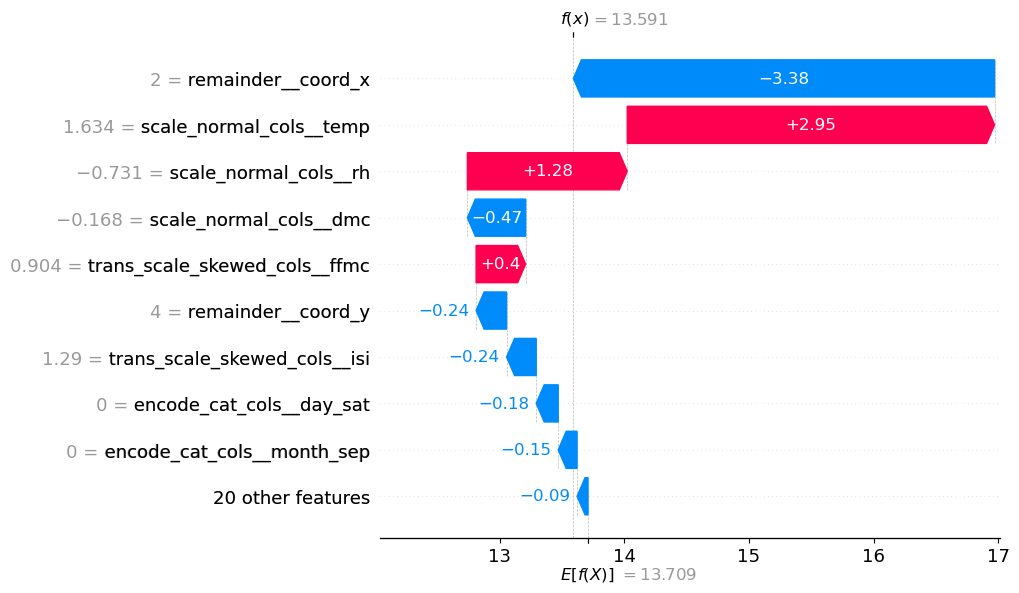

In [88]:
#For observation in row 2, which features are most important
shap.plots.waterfall(shap_values[1])

Answer: 
For the observation in Row 2, the most important features are as explained here:
1. coord_X - Location plays the most important role. The negative values explain the location of this observation reduces the prediced values (area for fire). 
2. temp - Temperature is second important and it increases the predicted values. The temperature of this observation increases prediced values. 
3. rh - Relative humidity is the third important factor. RH of this observation increases predicted values. 
4. dmc - Duff moisture code is the fourth important factor. The moisture content in the decaying organic material for this observation increases predicted values. 
All other features have little to no effect. 


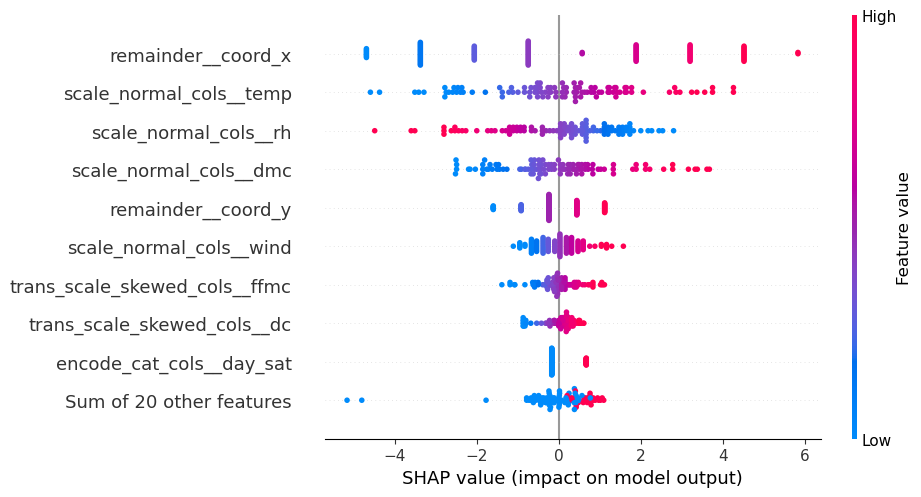

In [89]:
shap.plots.beeswarm(shap_values)

Answer: 
1. Across the training set, the x coordinate of the location (coord X), temperature (temp), relative humidity (rh) and moisture in decaying organic material (dmc) play the most important role and in that order. 
2. Other features that have some effect include the y coordinate of the location (coord Y), wind (wind), moisture in fuel such as grass (ffmc/fine fuel moisture content), moisture in duff (dc/similar to dmc) and saturday (day_sat) 
3. Rest of the factors such as month have little to no effect. 

I would remove the following features because they have little to no effect as per SHAP:
1. month 
2. rain 
It is counter intuitive though. Month (hotter months) should have effect on fire but there may be multicollinearity between temperature and month, making month less important. Similarly rain should have an effect but its effect may be captured better by humidity and moisture features. 

I would test this by excluding one variable (month or rain) at a time and seeing it's effect on the model's performance. 

## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.